# Logistic Regression and Decision Trees: Medium.com employee data

In this notebook we continue the analysis of the human resources data provided by Medium on Kaggle (https://www.kaggle.com/ludobenistant/hr-analytics). It is simulated employee data of 15000 employees, and the goal is to understand something about what might cause an employee to prematurely leave the company.

The fact that we have some useful demographics about our employees, and that we know if the employee left or not means we can apply machine learning, and we can use supervised learning algorithms. One of the benefits of machine learning algorithms is you don't have to do any preliminary data exploration - the algorithm can decide for itself if a feature is relevant or not. As this is a classification problem (with two outcomes, will leave, or will stay) I will apply initially two classification algorithms: logistic regression, and decision trees.

In [23]:
%matplotlib notebook

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm


In [25]:
from __future__ import print_function

In [26]:
sns.set_context("talk")

In [27]:
#data is comma-delimited csv, with headers in the first line
df = pd.read_csv('HR_comma_sep.csv')

In [28]:
#rename column sales to dept
df = df.rename(columns={'sales':'dept'})

In [29]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
dept                      object
salary                    object
dtype: object

In [30]:
#create dummy variables for columns that are categorical: dept, and salary
df = pd.get_dummies(df)

In [31]:
X = df.drop('left', axis=1).values
y = df.left.values

## Logistic regression

Logistic regression is a simple algorithm, but is a powerhouse - many problems can be modeled with this technique. How well will it work with our dataset?

As we have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data, it is common to divide the data into training and test subsets. A way to train and test, while subjecting all data to training and testing, is divide the data into equal parts, and cycle through these parts, where each cycle uses a different subset for testing. This is called a K-Folds cross validator, and the sci-kit learn package provides the indices for you.

The process is as follows:
* process data so all formats are numeric - create dummy variables for categorical data (boolean yes/no for each category) (done above)
* use built-in tool (GridSearchCV) for optimizing fit parameters, like C which is the inverse regularization coefficient 
* split data into training and test data, use StratifiedKFold to retain ratio of each category intact in each fold, since data is a little unbalanced (roughly a quarter is labeled true)
* for each "fold", train the model, and then test
* calculate prediction metrics, such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka reciever operating characteristic (ROC) curve
 * precision-recall (PR) curve (great for unbalanced datasets since it ignores true negatives)
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

In [33]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegression()
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X, y)
clf.best_params_

{'C': 1000}

In [34]:
# fine tune C value
Cs = [800, 850, 900, 950, 1000, 2000]
lr = LogisticRegression()
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X, y)
clf.best_params_

{'C': 900}

In [35]:
nfold = 3
y_test = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
offset = 0
clf = LogisticRegression(C=900)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_test[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    offset += len(test)

In [36]:
confusion_matrix(y_test, y_pred)

array([[10153,  1275],
       [ 2237,  1334]])

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute ROC curve and area the curve
def plot_roc(y_test,y_score):
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=lw,
             label='ROC')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
# Plot Precision-Recall curve
def plot_pr(y_test,y_score):
    lw = 2
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.figure()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    plt.show()

<IPython.core.display.Javascript object>


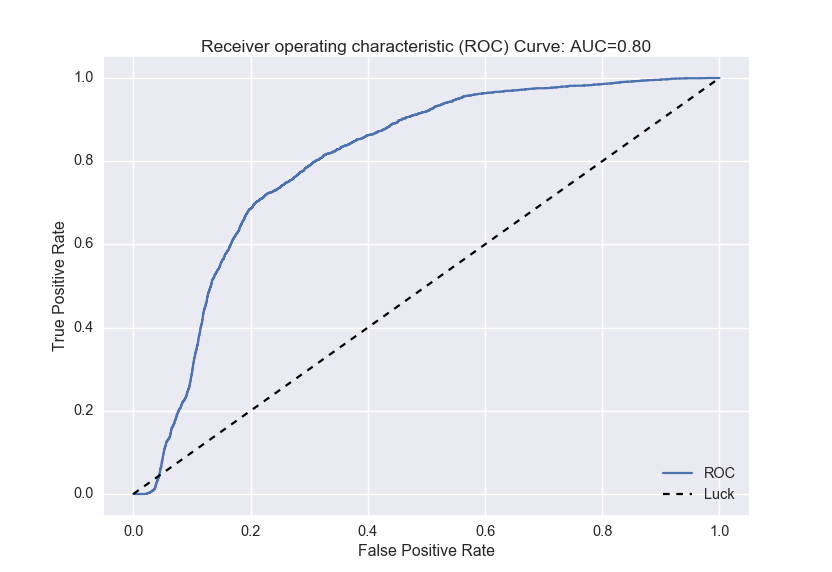

In [38]:
plot_roc(y_test,decfun)

<IPython.core.display.Javascript object>


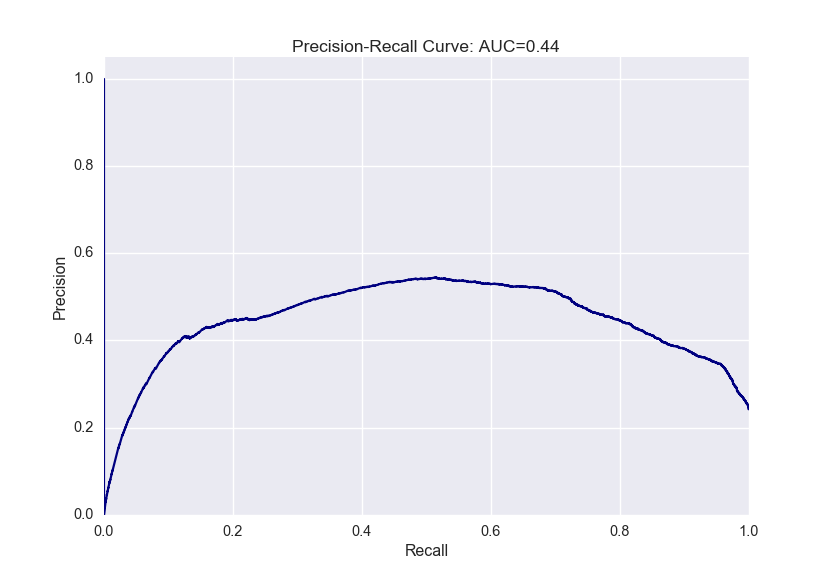

In [39]:
# Plot Precision-Recall curve
plot_pr(y_test,decfun)

## Decision trees

Decision trees, unlike logistic regression, don't normally need categorical data to be converted to dummy variables; however, sklearn does require this. A binary result in sklearn can have values [-1,1] but multiclass classification can take the values [0,..K-1] for K classes; I will keep the current [0,1] as they are.  

In [18]:
from sklearn import tree

In [19]:
nfold = 3
y_test = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
offset = 0
clf = tree.DecisionTreeClassifier()

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_test[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X[test])
    offset += len(test)

<IPython.core.display.Javascript object>


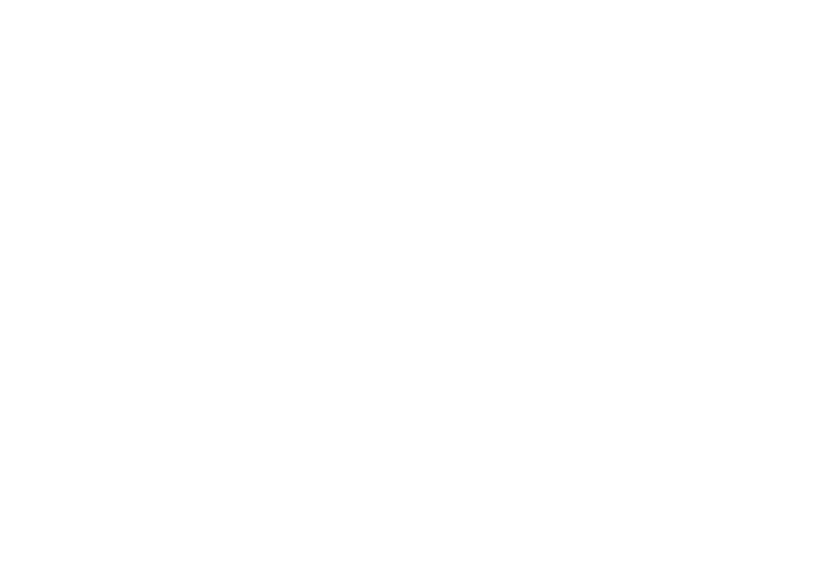

In [20]:
plot_roc(y_test,y_score[:,1])

<IPython.core.display.Javascript object>


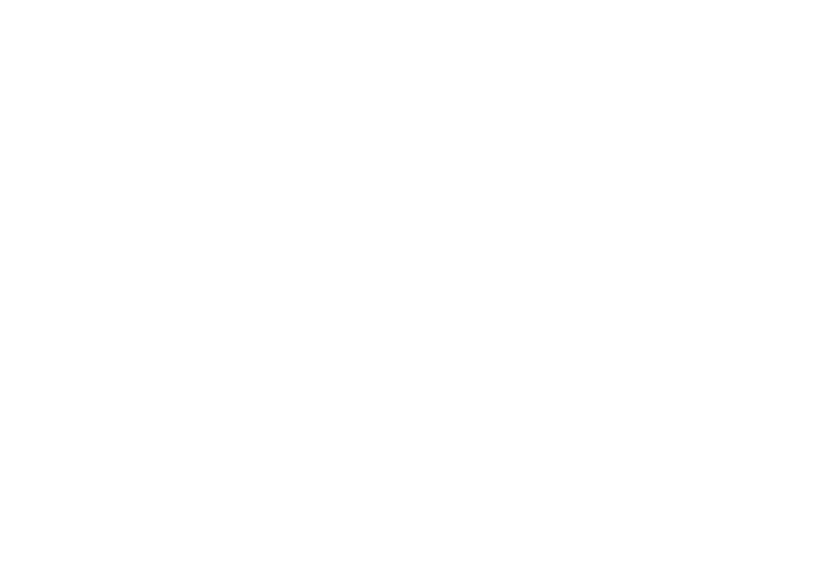

In [21]:
plot_pr(y_test,y_score[:,1])

Visualize the tree

In [22]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=df.columns[:-1],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 


InvocationException: GraphViz's executables not found